# Detect trucks using Sentinel-2
---
Author: Henrik Fisser, 2020

This script was developed and executed on the EOxHub-hosted JupyterLab and uses xcube for computations on data cubes retrieved from Sentinel Hub. If you do not have access to these resources you may execute the calculation as a Javascript on Sentinel-hub EO Browser. 
You find the Javascript here: https://github.com/hfisser/Truck_Detection_Sentinel2_COVID19/blob/master/detect_trucks_sentinel2.js

What does this script do?
----
It detects trucks in Sentinel-2 data. The detection exploits the offset of different wavelengths reflected by moving objects. It targets pixels where blue is higher than green and red. First, a road mask is calculated and the data is masked to these pixels. Second, the ratios between blue and green and blue and red are calculated. Finally, thresholds are applied to these ratios. Each truck is represented by one to three pixels with value 1 in the result. In order to visualize the results they may be vectorized, which this script does not do.

The first part of the notebook demonstrates the procedure at a single timestamp. The second part calculates the same for more timestamps.

Questions or Feedback?
---
Just send me a message :).

Load dependencies
---

In [1]:
# load creds
%load_ext dotenv
%dotenv

In [2]:
from xcube_sh.cube import open_cube
from xcube_sh.config import CubeConfig
from xcube.core.maskset import MaskSet

from osgeo import gdal, gdal_array, ogr

import os
import json
import numpy as np
import xarray as xr
import shapely.geometry
import IPython.display

%matplotlib inline

General parameters
---


In [3]:
dataset = "S2L2A"
spatial_res = 0.00009 # 10m
band_names = ["B02", "B03", "B04", "B08", "B11", "SCL"]
time_period = "1D"

fig = [16, 10] # for plotting

Specific parameters
---

In [4]:
min_rgb = 0.04
max_red = 0.15
max_green = 0.15
max_blue = 0.4
max_ndvi = 0.7 # quite high to account for mixed pixels
max_ndwi = 0.001
max_ndsi = 0.0001
min_b11 = 0.05
max_b11 = 0.55
min_green_ratio = 0.05
min_red_ratio = 0.1

Area Of Interest
---

In [5]:
aoi_rotterdam = 3.94, 51.6, 5.3, 52.15
aoi_milan = 9., 45.12, 10.1775, 45.69
aoi_ruhr = 6.7, 51.27, 7.58, 51.6
#place = "rotterdam"
#place = "milan"
place = "ruhr"
# dates where chosen according to available cloud-free acquisitions
dates_rotterdam = ["2019-02-15", "2019-02-25", "2019-04-01", # 2019
                   "2020-03-21", "2020-03-26", "2020-03-31", "2020-04-20"] # 2020
dates_milan = ["2019-04-17", "2020-04-06"]
dates_ruhr = ["2018-03-19", "2018-05-08", "2018-07-02", "2018-07-07", "2018-07-27", "2018-08-06", "2018-09-30", "2018-10-10",
              "2019-02-27", "2019-04-18", "2019-05-13", "2019-06-27", "2019-08-26", "2019-09-20", "2019-12-04", 
              "2020-02-07", "2020-03-23", "2020-03-28", "2020-04-17", "2020-04-22", "2020-05-07"]

dates = dates_ruhr
aoi = aoi_ruhr

IPython.display.GeoJSON(shapely.geometry.box(*aoi).__geo_interface__)

<IPython.display.GeoJSON object>

# Do calculation for a single timestamp
---

__1. Get Sentinel-2 L2A data__

In [14]:
cube_con = CubeConfig(dataset_name = dataset,
                      band_names = band_names,
                      tile_size = [512, 512],
                      geometry = aoi,
                      spatial_res = spatial_res,
                      time_range = [dates[0], dates[1]],
                      time_period = time_period)
cube = open_cube(cube_con)
scl = MaskSet(cube.SCL)
cube = cube.where((scl.clouds_high_probability) == 0)

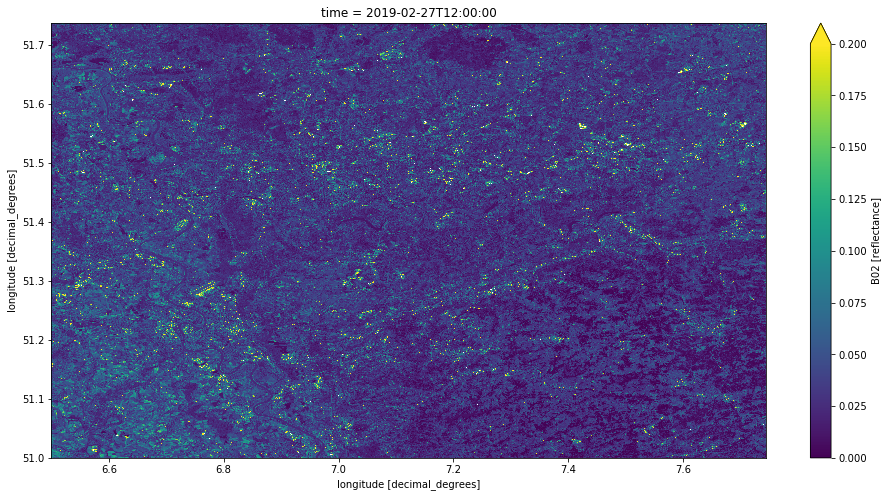

In [15]:
#date = dates[-1] # do exmaple calculation for last timestamp of dates
date = dates[0]
#timestamp1 = cube.sel(time = cube.time[-1])
timestamp1 = cube.sel(time = cube.time[0])
timestamp1.B02.plot.imshow(vmin = 0, vmax = 0.2, figsize = [16, 8])

This is for demonstration purpose. The calculation with more timestamps and a masking of wrongly detected invariant features is implemented in the consecutive section.

__2. Compute a roads mask using band ratios and thresholds__

In [18]:
B02 = timestamp1.B02
B03 = timestamp1.B03
B04 = timestamp1.B04
B08 = timestamp1.B08
B11 = timestamp1.B11
  
# Compute a roads mask using band ratios and thresholds
ndvi_mask = ((B08 - B04) / (B08 + B04)) < max_ndvi
ndwi_mask = ((B02 - B11) / (B02 + B11)) < max_ndwi
ndsi_mask = ((B03 - B11) / (B03 + B11)) < max_ndsi
low_rgb_mask = (B02 > min_rgb) * (B03 > min_rgb) * (B04 > min_rgb)
high_rgb_mask = (B02 < max_blue) * (B03 < max_green) * (B04 < max_red)
b11_mask = ((B11 - B03) / (B11 + B03)) < max_b11
b11_mask_abs = (B11 > min_b11) * (B11 < max_b11)
roads_mask = ndvi_mask * ndwi_mask * ndsi_mask * low_rgb_mask * high_rgb_mask * b11_mask * b11_mask_abs

_Plot road mask_

/opt/conda/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)
/opt/conda/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/opt/conda/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)
/opt/conda/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


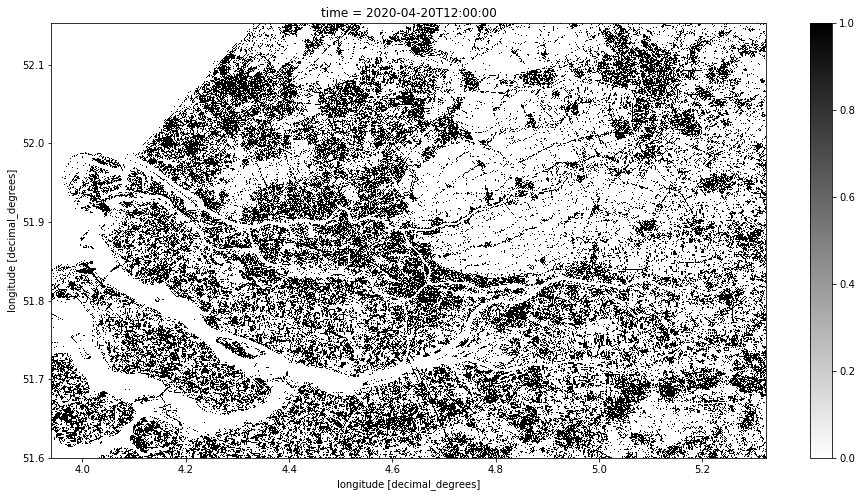

In [9]:
roads_mask.plot.imshow(vmin = 0, vmax = 1, cmap = "binary", figsize = [16, 8])
roads_mask.to_netcdf("roads_mask_example_" + date + ".nc")

__3. Extract vehicles from RGB ratios__

In [29]:
bg_ratio = (B02 - B03) / (B02 + B03) 
br_ratio = (B02 - B04) / (B02 + B04)

bg_low = (bg_ratio * roads_mask) > min_green_ratio 
br_low = (br_ratio * roads_mask) > min_red_ratio
vehicles = bg_low * br_low

_Plot vehicles_ \
__Note: In this plot you basically see nothing since the detected single pixels are too small to bee visible here. Vectorization of these pixels shows the result.__

/opt/conda/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)
/opt/conda/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/opt/conda/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)
/opt/conda/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


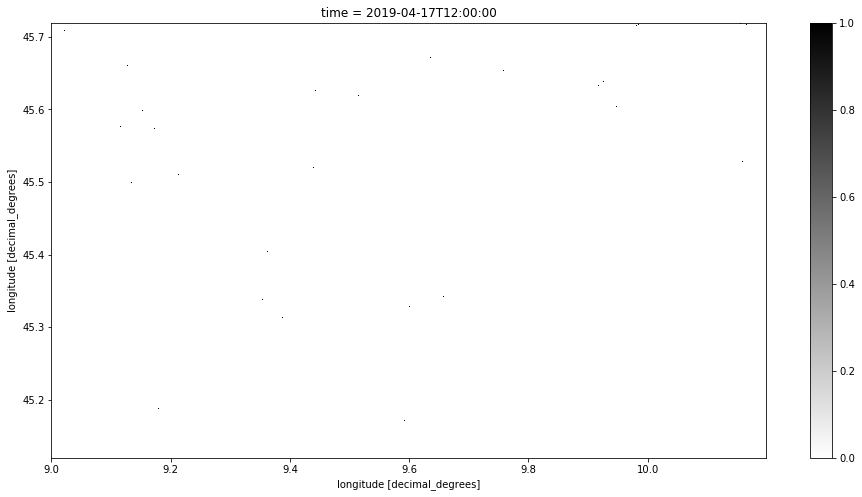

In [30]:
vehicles.plot.imshow(vmin = 0, vmax = 1, cmap = "binary", figsize = [16, 8])
vehicles.to_netcdf("vehicles_example_" + date + ".nc")

In [31]:
timestamp1.B02.to_netcdf("B02" + place + ".nc")
timestamp1.B03.to_netcdf("B03" + place + ".nc")
timestamp1.B04.to_netcdf("B04" + place + ".nc")

# Do calculation for more timestamps
---


__1. Get Sentinel-2 L2A data__

In [18]:
cube_con_2018 = CubeConfig(dataset_name = dataset,
                           band_names = band_names,
                           tile_size = [512, 512],
                           geometry = aoi,
                           spatial_res = spatial_res,
                           time_range = [dates[2], dates[4]],
                           time_period = time_period)
cube_con_2019 = CubeConfig(dataset_name = dataset,
                           band_names = band_names,
                           tile_size = [512, 512],
                           geometry = aoi,
                           spatial_res = spatial_res,
                           time_range = [dates[5], dates[6]],
                           time_period = time_period)
cube_con_2020 = CubeConfig(dataset_name = dataset,
                           band_names = band_names,
                           tile_size = [512, 512],
                           geometry = aoi,
                           spatial_res = spatial_res,
                           time_range = [dates[9], dates[12]],
                           time_period = time_period)
cube_2018 = open_cube(cube_con_2018)
cube_2019 = open_cube(cube_con_2019)
cube_2020 = open_cube(cube_con_2020)

# Write RGB of last date before masking
last_ts = cube_2020.sel(time = cube_2020.time[-1])
suffix = "_" + place + "_" + dates[-1] +  ".nc"
b02_path, b03_path, b04_path = "B02" + suffix, "B03" + suffix, "B04" + suffix
if not os.path.exists(b02_path): last_ts.B02.to_netcdf(b02_path)
if not os.path.exists(b03_path): last_ts.B03.to_netcdf(b03_path)
if not os.path.exists(b04_path): last_ts.B04.to_netcdf(b04_path)

# Mask out clouds of high probability    
scl_2018 = MaskSet(cube_2018.SCL)
scl_2019 = MaskSet(cube_2019.SCL)
scl_2020 = MaskSet(cube_2020.SCL)
cube_2018 = cube_2018.where((scl_2018.clouds_high_probability +
                             scl_2018.clouds_medium_probability +
                             scl_2018.clouds_low_probability_or_unclassified + 
                             scl_2018.cirrus) == 0)
cube_2019 = cube_2019.where((scl_2019.clouds_high_probability + 
                             scl_2019.clouds_medium_probability + 
                             scl_2019.clouds_low_probability_or_unclassified +
                             scl_2019.cirrus) == 0)
cube_2020 = cube_2020.where((scl_2020.clouds_high_probability +
                             scl_2020.clouds_medium_probability +
                             scl_2020.clouds_low_probability_or_unclassified + 
                             scl_2020.cirrus) == 0)

__2. Calculate road mask and vehicle layer timestamp-wise__

In [19]:
vehicles_results = {} # will hold vehicle masks of all timestamps
for date in dates:
    #cube = cube_2019 if date.startswith("2019") else cube_2020
    cube = cube_2018 #if date.startswith("2018") else cube
    date_formatted = str(cube.time.values[[str(t).startswith(date) for t in cube.time.values]][0])
    timestamp = cube.sel(time = date_formatted)
    B02 = timestamp.B02
    B03 = timestamp.B03
    B04 = timestamp.B04
    B08 = timestamp.B08
    B11 = timestamp.B11
    
    # Compute a roads mask using band ratios and thresholds
    ndvi_mask = ((B08 - B04) / (B08 + B04)) < max_ndvi
    ndwi_mask = ((B02 - B11) / (B02 + B11)) < max_ndwi
    ndsi_mask = ((B03 - B11) / (B03 + B11)) < max_ndsi
    low_rgb_mask = (B02 > min_rgb) * (B03 > min_rgb) * (B04 > min_rgb)
    high_rgb_mask = (B02 < max_blue) * (B03 < max_green) * (B04 < max_red)
    b11_mask = ((B11 - B03) / (B11 + B03)) < max_b11
    b11_mask_abs = (B11 > min_b11) * (B11 < max_b11)
    roads_mask = ndvi_mask * ndwi_mask * ndsi_mask * low_rgb_mask * high_rgb_mask * b11_mask * b11_mask_abs  
    
    # Extract vehicles from RGB ratios
    bg_ratio = (B02 - B03) / (B02 + B03)
    br_ratio = (B02 - B04) / (B02 + B04)
    bg_low = (bg_ratio * roads_mask) > min_green_ratio
    br_low = (br_ratio * roads_mask) > min_red_ratio
       
    if date == dates[-1]:
        bg_ratio_path = "bg_ratio.nc"
        br_ratio_path = "br_ratio.nc"
        bg_mask_path = "bg_mask.nc"
        br_mask_path = "br_mask.nc"
        roads_path = "road_mask.nc"
        if not os.path.exists(bg_ratio_path): bg_ratio.to_netcdf(bg_ratio_path)
        if not os.path.exists(br_ratio_path): br_ratio.to_netcdf(br_ratio_path)
        if not os.path.exists(bg_mask_path): bg_low.to_netcdf(bg_mask_path)
        if not os.path.exists(br_mask_path): br_low.to_netcdf(br_mask_path)
        if not os.path.exists(roads_path): roads_mask.to_netcdf(roads_path)
    
    vehicles = bg_low * br_low
    vehicles_results[date] = vehicles

__3. Write results__

In [20]:
suffix = "_" + place + ".nc"
for i in range(0, len(dates)):
    if not os.path.exists(dates[i] + suffix): vehicles_results[dates[i]].to_netcdf(dates[i] + suffix)

/opt/conda/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)
/opt/conda/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
